In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import HTML, display
from typing import Callable
from celluloid import Camera

# 1D Wave

In [104]:
class Wave1D:
    def __init__(self, u, L, dx, dt, f, g, h=None, left_free=False, right_free=False, x0=0, ddf=None):
        N = int((L-x0)/dx)
        self.lamb = (u*dt/dx)**2
        self.LAMB = 2*(1 - self.lamb)*np.identity(N-2) + self.lamb*(np.diagflat(np.ones(N-3), 1) + np.diagflat(np.ones(N-3), -1))

        self._h = h
        self.N = N
        self.dt = dt
        self._t = [0, 1]
        self.left_free = left_free
        self.right_free = right_free

        self.x = np.linspace(x0, L, N)
        self._f0 = f(0)
        self._fL = f(L)

        xi = self.x[1:-1]
        y0 = f(xi)
        self._Y = [y0]
        y1 = y0 + dt*g(xi)
        if ddf != None:
            y1 += (u*dt)**2*ddf(xi)/2
        else:
            y1 += (self.lamb/2)*(f(self.x[2:]) + f(self.x[:-2])) + (dt**2/2)*self.h(0) - self.lamb*y0
        self._Y.append(y1)

    def _get_alpha(self, i):
        return self._f0 if not self.left_free else self._Y[i][0]
    
    def _get_beta(self, i):
        return self._fL if not self.right_free else self._Y[i][-1]
    
    @property
    def y(self):
        return np.r_[self._get_alpha(-1), self._Y[-1], self._get_beta(-1)]
    
    @property
    def t(self):
        return np.stack(self._t)
    
    @property
    def Y(self):
        return np.stack([
            np.r_[
                self._get_alpha(i), 
                self._Y[i], 
                self._get_beta(i),
            ] 
            for i in range(len(self._Y))
        ])
    
    @property
    def b(self):
        return np.r_[self._get_alpha(-1), np.zeros(self.N-4), self._get_beta(-1)]
    
    def h(self, i):
        if self._h == None:
            return 0
        else:
            return self._h(self._t[i], self.x[1:-1], self._Y[i])
    
    def step(self):
        y = self.LAMB.dot(self._Y[-1]) - self._Y[-2] + self.lamb*self.b + self.dt**2*self.h(-1)
        self._Y.append(y)
        self._t.append(self._t[-1] + self.dt)
        return y

In [62]:
def show(animation):
    plt.close()
    return HTML(animation.to_html5_video())

In [63]:
wave = Wave1D(1, 1, 0.05, 0.01, lambda x: np.sin(np.pi*x), lambda x: 0)

camera = Camera(plt.gcf())
for _ in range(500):
    wave.step()
    plt.plot(wave.x, wave.y, 'C0-')
    camera.snap()
show(camera.animate(interval=5))

In [98]:
def f(x):
    return np.exp(-x**2)

wave = Wave1D(2, 10, 0.05, 0.01, f, lambda x: 0, left_free=True)

camera = Camera(plt.gcf())
for _ in range(1000):
    wave.step()
    plt.plot(wave.x, wave.y, 'C0-')
    camera.snap()
show(camera.animate(interval=5))

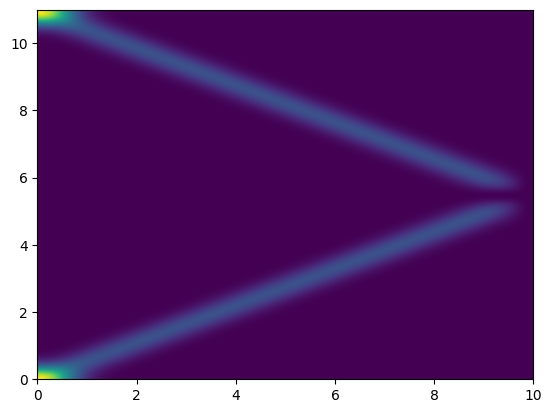

In [99]:
plt.imshow(wave.Y**2, aspect='auto', origin='lower', extent=(wave.x.min(), wave.x.max(), wave.t.min(), wave.t.max()))

In [111]:
wave = Wave1D(1, 10, 0.05, 0.01, lambda x: 0 if type(x) in (int, float) else np.zeros(x.shape), lambda x: 0, h=lambda t, x, y: -0.1)

camera = Camera(plt.gcf())
for _ in range(1000):
    wave.step()
    plt.plot(wave.x, wave.y, 'C0-')
    camera.snap()
show(camera.animate(interval=5)) 

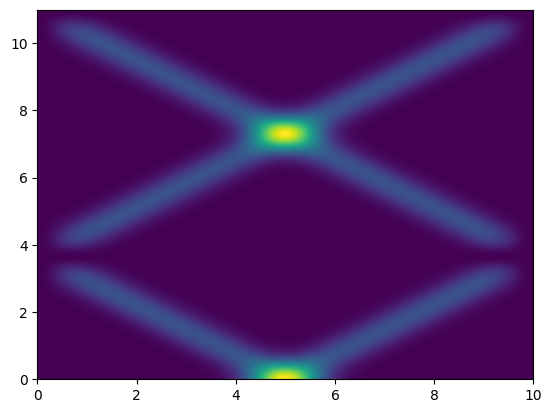

In [85]:
plt.imshow(wave.Y**2, aspect='auto', origin='lower', extent=(wave.x.min(), wave.x.max(), wave.t.min(), wave.t.max()))

In [86]:
wave = Wave1D(v, 10, 0.05, 0.01, lambda x: np.exp(-(x - 5)**2), lambda x: 0, right_fixed=False)

camera = Camera(plt.gcf())
for _ in range(1000):
    wave.step()
    plt.plot(wave.x, wave.y, 'C0-')
    camera.snap()
show(camera.animate(interval=5)) 

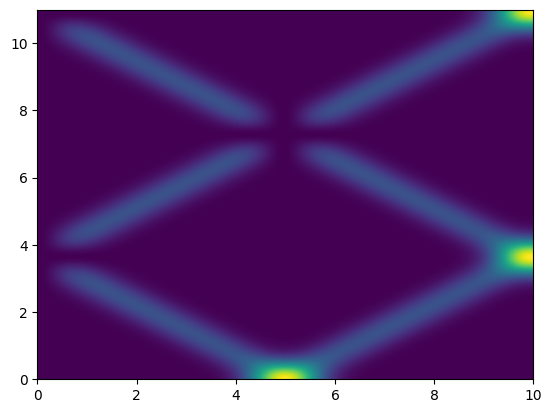

In [87]:
plt.imshow(wave.Y**2, aspect='auto', origin='lower', extent=(wave.x.min(), wave.x.max(), wave.t.min(), wave.t.max()))

In [116]:
c = 1
v = 0.9
x0 = 2
gamma = 1/np.sqrt(1 - (v/c)**2)
lamb = 1
wave = Wave1D(c, 10, 0.05, 0.01, lambda x: np.tanh(gamma*(x - x0)), lambda x: -gamma*v/np.cosh(gamma*(x - x0))**2, h= lambda t, x, y: lamb*y*(1 - y**2))

camera = Camera(plt.gcf())
for _ in range(5000):
    wave.step()
    plt.plot(wave.x, wave.y, 'C0-')
    camera.snap()
show(camera.animate(interval=5))

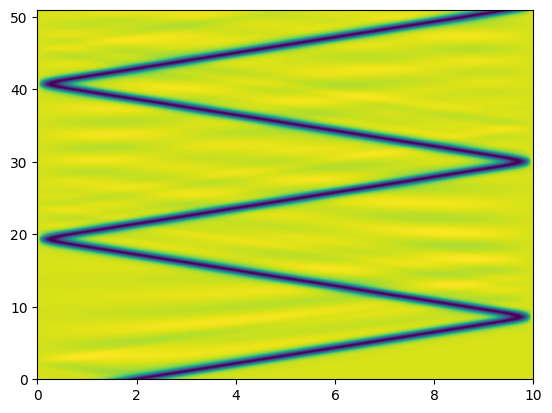

In [117]:
plt.imshow(wave.Y**2, aspect='auto', origin='lower', extent=(wave.x.min(), wave.x.max(), wave.t.min(), wave.t.max()))

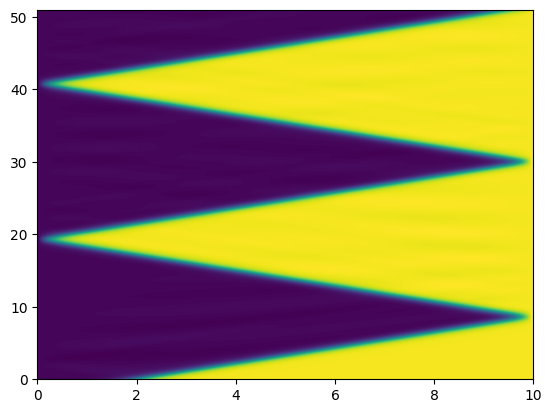

In [118]:
plt.imshow(wave.Y, aspect='auto', origin='lower', extent=(wave.x.min(), wave.x.max(), wave.t.min(), wave.t.max()))